In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn import preprocessing
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import classification_report

import nltk
from nltk import pos_tag
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import word_tokenize
from nltk.tokenize import WhitespaceTokenizer
from nltk.corpus import stopwords
from nltk.corpus import wordnet

from nltk.sentiment.vader import SentimentIntensityAnalyzer

In [2]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Utkarsh.Goyal\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Utkarsh.Goyal\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [4]:
nltk.download('omw-1.4')

[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\Utkarsh.Goyal\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [5]:
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Utkarsh.Goyal\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [6]:
df = pd.read_csv('b.csv', encoding = 'ISO-8859-1', usecols=[ 'Review', 'Rating'])
df.head()

,Review,Rating
0,nice hotel expensive parking got good deal sta...,4
1,ok nothing special charge diamond member hilto...,2
2,nice rooms not 4* experience hotel monaco seat...,3
3,unique \tgreat stay \twonderful time hotel mon...,5
4,great stay great stay \twent seahawk game awes...,5


In [7]:
import re

def remove_stopwords(input_text):
        stopwords_list = stopwords.words('english')
        # Some words which might indicate a certain sentiment are kept via a whitelist
        whitelist = ["n't", "not", "no"]
        words = input_text.split() 
        clean_words = [word for word in words if (word not in stopwords_list or word in whitelist) and len(word) > 1] 
        return " ".join(clean_words) 

def normalize(i):
#     for i in data:
    i = re.sub("(#[A-Za-z0-9]+)|(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)","",i)
    
    i = i.lower()
    # get rid of urls
    i = re.sub('https?://\S+|www\.\S+', '', i)
    i = re.sub('<[^>]*>', '', i)
    i = re.sub(r'[^\w\s]','', i)
    i = re.sub(r'\$\w*','', i)
    i = re.sub(r'^RT[\s]+','', i)
    i = re.sub(r'http\S+','', i)
    i = re.sub(r'#','', i)

    # get rid of non words and extra spaces
    i = re.sub('\\W', ' ', i)
    i = re.sub('\n', '', i)
    i = re.sub(' +', ' ', i)
    i = re.sub('^ ', '', i)
    i = re.sub(' $', '', i)
    
    return i

In [8]:
df['Review1'] = df.Review.apply(remove_stopwords)
df['Clean_Review'] = df['Review1'].apply(normalize)

df['posneg'] = df['Rating'].apply(lambda x: 0 if x < 5 else 1)

In [9]:
df.head()

,Review,Rating,Review1,Clean_Review,posneg
0,nice hotel expensive parking got good deal sta...,4,nice hotel expensive parking got good deal sta...,nice hotel expensive parking got good deal sta...,0
1,ok nothing special charge diamond member hilto...,2,ok nothing special charge diamond member hilto...,ok nothing special charge diamond member hilto...,0
2,nice rooms not 4* experience hotel monaco seat...,3,nice rooms not 4* experience hotel monaco seat...,nice rooms not 4 experience hotel monaco seatt...,0
3,unique \tgreat stay \twonderful time hotel mon...,5,unique great stay wonderful time hotel monaco ...,unique great stay wonderful time hotel monaco ...,1
4,great stay great stay \twent seahawk game awes...,5,great stay great stay went seahawk game awesom...,great stay great stay went seahawk game awesom...,1


# CountVectorizer

In [10]:
from sklearn.feature_extraction.text import CountVectorizer

In [11]:
vect = CountVectorizer()
X = vect.fit_transform(df['Clean_Review'])
y = df['posneg'].values

In [12]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=0, stratify=y)

## Random Forest

In [13]:
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [14]:
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
y_pred = model.predict(X_test)
print("---Test Set Results---")
print("Accuracy with randomforest: {}".format(accuracy_score(y_test, y_pred)))
print(classification_report(y_test, y_pred))

---Test Set Results---
Accuracy with randomforest: 0.7601854110758721
              precision    recall  f1-score   support

           0       0.74      0.87      0.80      2288
           1       0.79      0.62      0.70      1811

    accuracy                           0.76      4099
   macro avg       0.77      0.75      0.75      4099
weighted avg       0.77      0.76      0.75      4099



In [15]:
binary_predictions = []

for i in y_pred:
    if i >= 0.5:
        binary_predictions.append(1)
    else:
        binary_predictions.append(0)

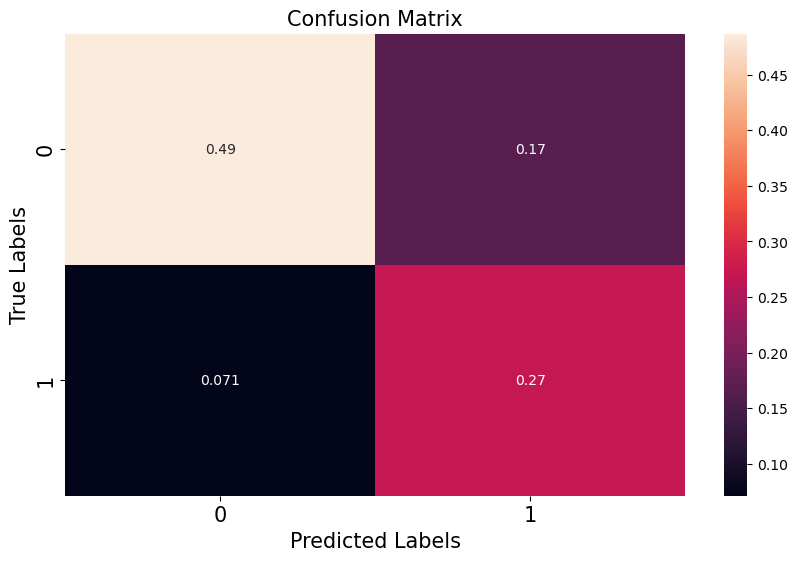

In [16]:
import seaborn as sns
matrix = confusion_matrix(binary_predictions, y_test, normalize='all')
plt.figure(figsize=(10, 6))
ax= plt.subplot()
sns.heatmap(matrix, annot=True, ax = ax)

# labels, title and ticks
ax.set_xlabel('Predicted Labels', size=15)
ax.set_ylabel('True Labels', size=15)
ax.set_title('Confusion Matrix', size=15)
ax.xaxis.set_ticklabels([0,1], size=15)
ax.yaxis.set_ticklabels([0,1], size=15);

## Logistic Regression

In [17]:
from sklearn.linear_model import LogisticRegression

In [18]:
clf = LogisticRegression(C=5, solver='liblinear').fit(X_train, y_train)

In [19]:
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
y_pred = clf.predict(X_test)
print("---Test Set Results---")
print("Accuracy with logreg: {}".format(accuracy_score(y_test, y_pred)))
print(classification_report(y_test, y_pred))

---Test Set Results---
Accuracy with logreg: 0.7575018297145645
              precision    recall  f1-score   support

           0       0.79      0.77      0.78      2288
           1       0.72      0.74      0.73      1811

    accuracy                           0.76      4099
   macro avg       0.75      0.76      0.75      4099
weighted avg       0.76      0.76      0.76      4099



In [20]:
binary_predictions = []

for i in y_pred:
    if i >= 0.5:
        binary_predictions.append(1)
    else:
        binary_predictions.append(0)

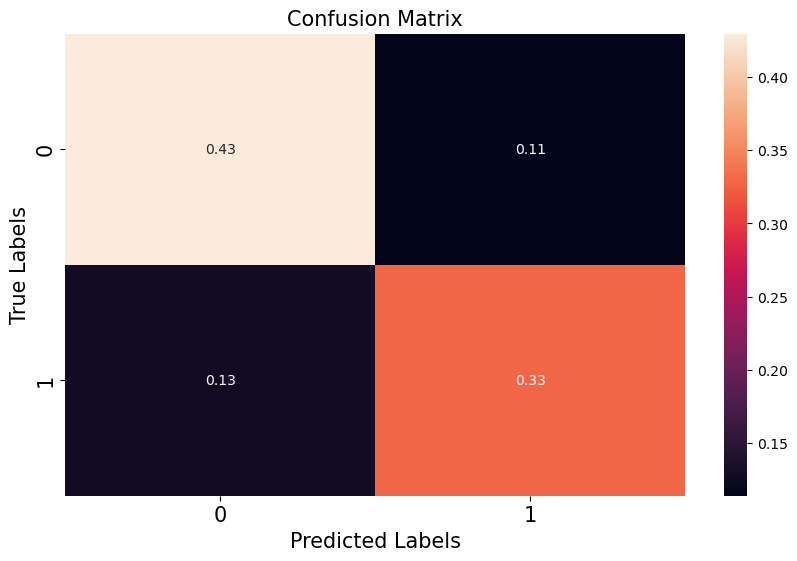

In [21]:
import seaborn as sns
matrix = confusion_matrix(binary_predictions, y_test, normalize='all')
plt.figure(figsize=(10, 6))
ax= plt.subplot()
sns.heatmap(matrix, annot=True, ax = ax)

# labels, title and ticks
ax.set_xlabel('Predicted Labels', size=15)
ax.set_ylabel('True Labels', size=15)
ax.set_title('Confusion Matrix', size=15)
ax.xaxis.set_ticklabels([0,1], size=15)
ax.yaxis.set_ticklabels([0,1], size=15);

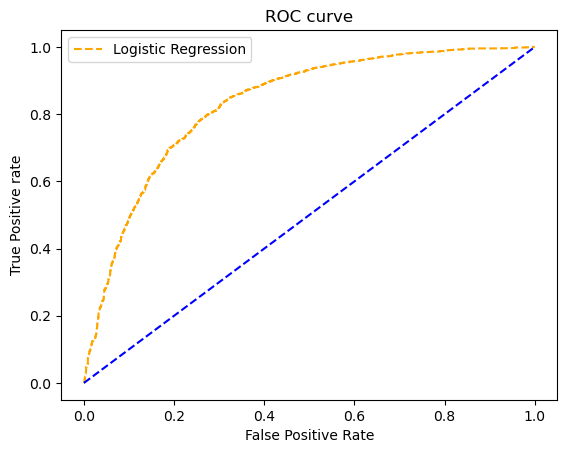

AUC score: 0.8315


In [22]:
from sklearn.metrics import roc_curve, roc_auc_score

pred_prob1 = clf.predict_proba(X_test)

auc_score1 = roc_auc_score(y_test, pred_prob1[:,1])


fpr1, tpr1, thresh1 = roc_curve(y_test, pred_prob1[:,1], pos_label=1)

# roc curve for tpr = fpr 
random_probs = [0 for i in range(len(y_test))]
p_fpr, p_tpr, _ = roc_curve(y_test, random_probs, pos_label=1)

# plot roc curves
plt.plot(fpr1, tpr1, linestyle='--',color='orange', label='Logistic Regression')
plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')
# title
plt.title('ROC curve')
# x label
plt.xlabel('False Positive Rate')
# y label
plt.ylabel('True Positive rate')

plt.legend(loc='best')
# plt.savefig('ROC',dpi=300)
plt.show();

print('AUC score:',round(auc_score1, 4))

# CountVectorizer Bigrams

In [23]:
from sklearn.feature_extraction.text import CountVectorizer

In [24]:
vect = CountVectorizer(min_df = 5, ngram_range = (1,2))
X = vect.fit_transform(df['Clean_Review'])
y = df['posneg'].values

In [25]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=0, stratify=y)

## Random Forest

In [26]:
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [27]:
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
y_pred = model.predict(X_test)
print("---Test Set Results---")
print("Accuracy with randomforest: {}".format(accuracy_score(y_test, y_pred)))
print(classification_report(y_test, y_pred))

---Test Set Results---
Accuracy with randomforest: 0.7670163454501098
              precision    recall  f1-score   support

           0       0.75      0.87      0.81      2288
           1       0.79      0.64      0.71      1811

    accuracy                           0.77      4099
   macro avg       0.77      0.75      0.76      4099
weighted avg       0.77      0.77      0.76      4099



In [28]:
binary_predictions = []

for i in y_pred:
    if i >= 0.5:
        binary_predictions.append(1)
    else:
        binary_predictions.append(0)

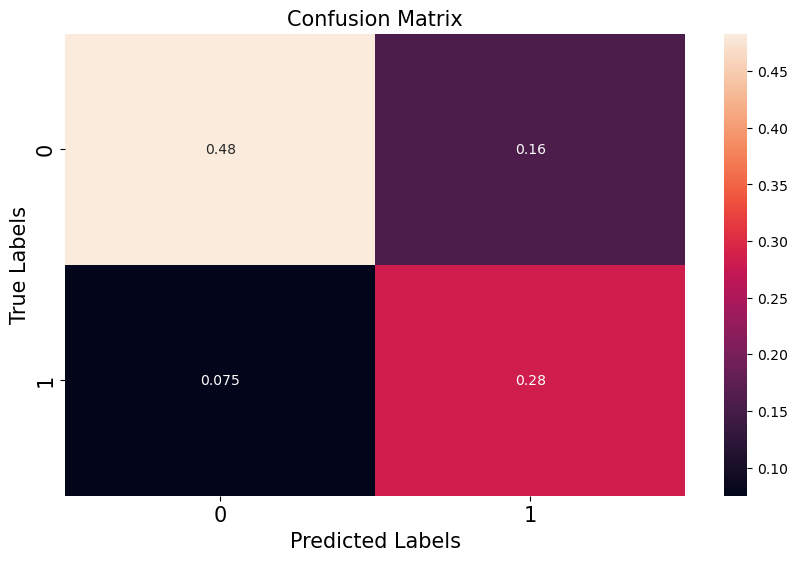

In [29]:
import seaborn as sns
matrix = confusion_matrix(binary_predictions, y_test, normalize='all')
plt.figure(figsize=(10, 6))
ax= plt.subplot()
sns.heatmap(matrix, annot=True, ax = ax)

# labels, title and ticks
ax.set_xlabel('Predicted Labels', size=15)
ax.set_ylabel('True Labels', size=15)
ax.set_title('Confusion Matrix', size=15)
ax.xaxis.set_ticklabels([0,1], size=15)
ax.yaxis.set_ticklabels([0,1], size=15);

## Logistic Regression

In [30]:
from sklearn.linear_model import LogisticRegression

In [31]:
clf = LogisticRegression(C=5, solver='liblinear').fit(X_train, y_train)

In [32]:
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
y_pred = clf.predict(X_test)
print("---Test Set Results---")
print("Accuracy with logreg: {}".format(accuracy_score(y_test, y_pred)))
print(classification_report(y_test, y_pred))

---Test Set Results---
Accuracy with logreg: 0.7811661380824592
              precision    recall  f1-score   support

           0       0.81      0.80      0.80      2288
           1       0.75      0.76      0.76      1811

    accuracy                           0.78      4099
   macro avg       0.78      0.78      0.78      4099
weighted avg       0.78      0.78      0.78      4099



In [33]:
binary_predictions = []

for i in y_pred:
    if i >= 0.5:
        binary_predictions.append(1)
    else:
        binary_predictions.append(0)

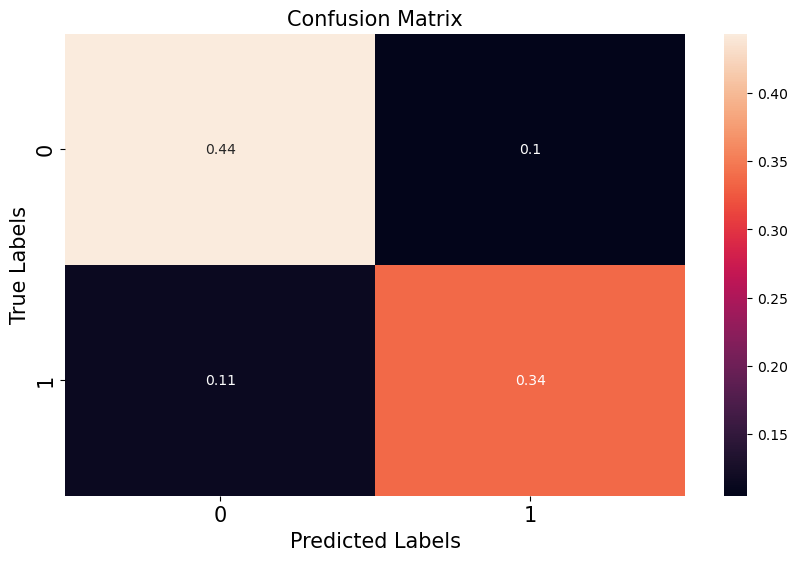

In [34]:
import seaborn as sns
matrix = confusion_matrix(binary_predictions, y_test, normalize='all')
plt.figure(figsize=(10, 6))
ax= plt.subplot()
sns.heatmap(matrix, annot=True, ax = ax)

# labels, title and ticks
ax.set_xlabel('Predicted Labels', size=15)
ax.set_ylabel('True Labels', size=15)
ax.set_title('Confusion Matrix', size=15)
ax.xaxis.set_ticklabels([0,1], size=15)
ax.yaxis.set_ticklabels([0,1], size=15);

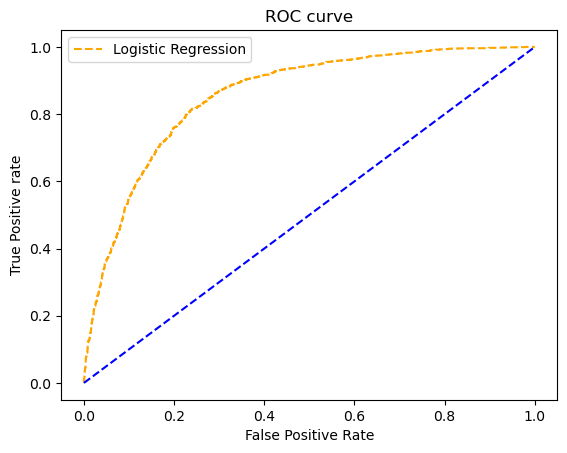

AUC score: 0.8553


In [35]:
from sklearn.metrics import roc_curve, roc_auc_score

pred_prob1 = clf.predict_proba(X_test)

auc_score1 = roc_auc_score(y_test, pred_prob1[:,1])


fpr1, tpr1, thresh1 = roc_curve(y_test, pred_prob1[:,1], pos_label=1)

# roc curve for tpr = fpr 
random_probs = [0 for i in range(len(y_test))]
p_fpr, p_tpr, _ = roc_curve(y_test, random_probs, pos_label=1)

# plot roc curves
plt.plot(fpr1, tpr1, linestyle='--',color='orange', label='Logistic Regression')
plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')
# title
plt.title('ROC curve')
# x label
plt.xlabel('False Positive Rate')
# y label
plt.ylabel('True Positive rate')

plt.legend(loc='best')
# plt.savefig('ROC',dpi=300)
plt.show();

print('AUC score:',round(auc_score1, 4))

# TFIDF

In [36]:
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer

In [37]:
porter = PorterStemmer()

def tokenizer_porter(text):
    return [porter.stem(word) for word in text.split()]

In [38]:
tfidf = TfidfVectorizer(strip_accents=None,
                        lowercase=False,
                        preprocessor=None,
                        tokenizer=tokenizer_porter,
                        use_idf=True,
                        norm='l2',
                        smooth_idf=True)
X = tfidf.fit_transform(df['Clean_Review'])
y = df['posneg'].values

C:\Users\Utkarsh.Goyal\AppData\Roaming\Python\Python310\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [39]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=0, stratify=y)

## Random Forest

In [40]:
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [41]:
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
y_pred = model.predict(X_test)
print("---Test Set Results---")
print("Accuracy with randonforest: {}".format(accuracy_score(y_test, y_pred)))
print(classification_report(y_test, y_pred))

---Test Set Results---
Accuracy with randonforest: 0.7531105147596975
              precision    recall  f1-score   support

           0       0.74      0.87      0.80      2288
           1       0.78      0.61      0.69      1811

    accuracy                           0.75      4099
   macro avg       0.76      0.74      0.74      4099
weighted avg       0.76      0.75      0.75      4099



In [42]:
binary_predictions = []

for i in y_pred:
    if i >= 0.5:
        binary_predictions.append(1)
    else:
        binary_predictions.append(0)

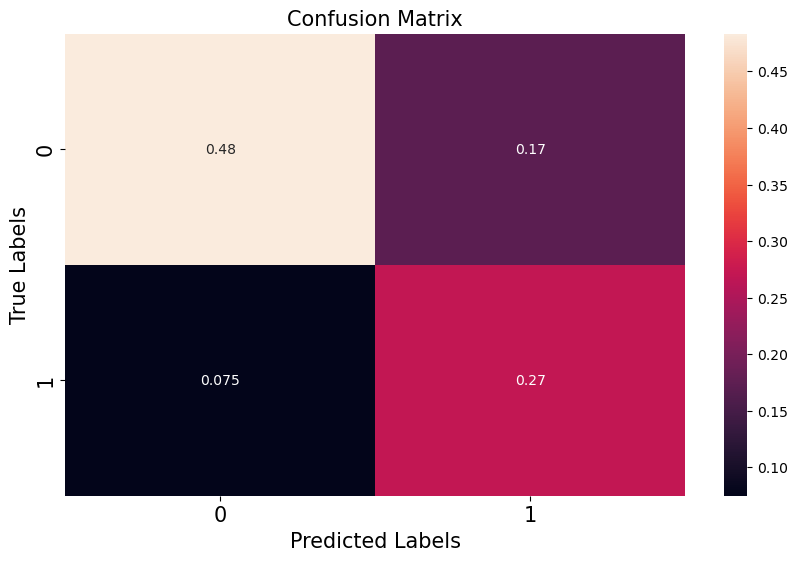

In [43]:
import seaborn as sns
matrix = confusion_matrix(binary_predictions, y_test, normalize='all')
plt.figure(figsize=(10, 6))
ax= plt.subplot()
sns.heatmap(matrix, annot=True, ax = ax)

# labels, title and ticks
ax.set_xlabel('Predicted Labels', size=15)
ax.set_ylabel('True Labels', size=15)
ax.set_title('Confusion Matrix', size=15)
ax.xaxis.set_ticklabels([0,1], size=15)
ax.yaxis.set_ticklabels([0,1], size=15);

## Logistic Regression

In [44]:
from sklearn.linear_model import LogisticRegression

In [45]:
clf = LogisticRegression(C=5, solver='liblinear').fit(X_train, y_train)

In [46]:
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
y_pred = clf.predict(X_test)
print("---Test Set Results---")
print("Accuracy with logreg: {}".format(accuracy_score(y_test, y_pred)))
print(classification_report(y_test, y_pred))

---Test Set Results---
Accuracy with logreg: 0.7901927299341303
              precision    recall  f1-score   support

           0       0.81      0.81      0.81      2288
           1       0.76      0.77      0.76      1811

    accuracy                           0.79      4099
   macro avg       0.79      0.79      0.79      4099
weighted avg       0.79      0.79      0.79      4099



In [47]:
binary_predictions = []

for i in y_pred:
    if i >= 0.5:
        binary_predictions.append(1)
    else:
        binary_predictions.append(0)

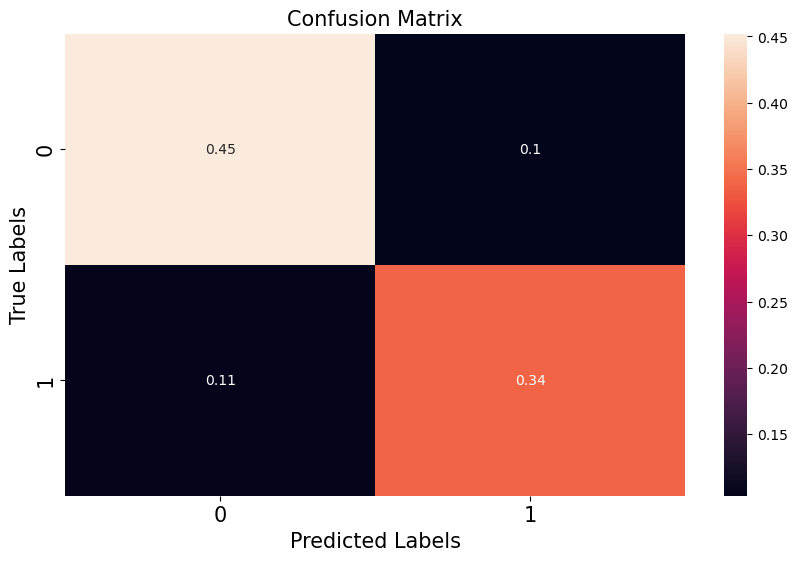

In [48]:
import seaborn as sns
matrix = confusion_matrix(binary_predictions, y_test, normalize='all')
plt.figure(figsize=(10, 6))
ax= plt.subplot()
sns.heatmap(matrix, annot=True, ax = ax)

# labels, title and ticks
ax.set_xlabel('Predicted Labels', size=15)
ax.set_ylabel('True Labels', size=15)
ax.set_title('Confusion Matrix', size=15)
ax.xaxis.set_ticklabels([0,1], size=15)
ax.yaxis.set_ticklabels([0,1], size=15);

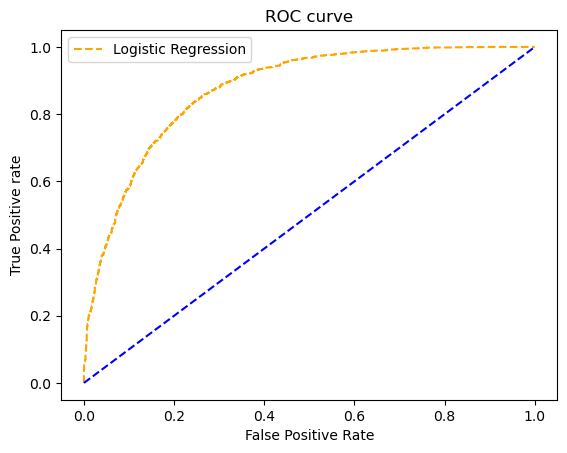

AUC score: 0.8749


In [49]:
from sklearn.metrics import roc_curve, roc_auc_score

pred_prob1 = clf.predict_proba(X_test)

auc_score1 = roc_auc_score(y_test, pred_prob1[:,1])


fpr1, tpr1, thresh1 = roc_curve(y_test, pred_prob1[:,1], pos_label=1)

# roc curve for tpr = fpr 
random_probs = [0 for i in range(len(y_test))]
p_fpr, p_tpr, _ = roc_curve(y_test, random_probs, pos_label=1)

# plot roc curves
plt.plot(fpr1, tpr1, linestyle='--',color='orange', label='Logistic Regression')
plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')
# title
plt.title('ROC curve')
# x label
plt.xlabel('False Positive Rate')
# y label
plt.ylabel('True Positive rate')

plt.legend(loc='best')
# plt.savefig('ROC',dpi=300)
plt.show();

print('AUC score:',round(auc_score1, 4))

# NN

## Sequential Model

In [50]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text

from tensorflow.keras.preprocessing.text import Tokenizer

In [51]:
bert_preprocess = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
bert_encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/2")

In [52]:
X = df['Clean_Review']
y = df['posneg'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0, stratify=y)

In [53]:
vocab_size = 100000
embedding_dim = 64
max_length = 128
trunc_type = 'post'
padding_type = 'post'
oov_tok = '<OOV>'

In [54]:
# Bert layers
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
preprocessed_text = bert_preprocess(text_input)
outputs = bert_encoder(preprocessed_text)

# Neural network layers
hidden1 = tf.keras.layers.Dense(64, activation='sigmoid')(outputs['pooled_output'])
dropout1 = tf.keras.layers.Dropout(0.1, name="dropout")(hidden1)
hidden2 = tf.keras.layers.Dense(32, activation='sigmoid')(dropout1)
dropout2 = tf.keras.layers.Dropout(0.1, name="dropout2")(hidden2)
hidden3 = tf.keras.layers.Dense(16, activation='sigmoid')(dropout2)
l = tf.keras.layers.Dense(1, activation='sigmoid', name="output")(hidden3)

# l = tf.keras.layers.Dropout(0.1, name="dropout")(outputs['pooled_output'])
# l = tf.keras.layers.Dense(1, activation='sigmoid', name="output")(l)

# Use inputs and outputs to construct a final model
model = tf.keras.Model(inputs=[text_input], outputs = [l])

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 keras_layer (KerasLayer)       {'input_type_ids':   0           ['text[0][0]']                   
                                (None, 128),                                                      
                                 'input_word_ids':                                                
                                (None, 128),                                                      
                                 'input_mask': (Non                                               
                                e, 128)}                                                      

In [55]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)
METRICS = [tf.keras.metrics.BinaryAccuracy(name='accuracy')]
model.compile(loss=tf.keras.losses.BinaryCrossentropy(), optimizer=tf.keras.optimizers.Adam(1e-4), metrics=METRICS)

In [56]:
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test), batch_size=100, shuffle=True, callbacks=[early_stop])

Epoch 1/10
154/154 [==============================] - 57s 356ms/step - loss: 0.6865 - accuracy: 0.5580 - val_loss: 0.6851 - val_accuracy: 0.5581
Epoch 2/10
154/154 [==============================] - 57s 372ms/step - loss: 0.6853 - accuracy: 0.5580 - val_loss: 0.6840 - val_accuracy: 0.5581
Epoch 3/10
154/154 [==============================] - 56s 366ms/step - loss: 0.6835 - accuracy: 0.5583 - val_loss: 0.6827 - val_accuracy: 0.5581
Epoch 4/10
154/154 [==============================] - 55s 355ms/step - loss: 0.6821 - accuracy: 0.5582 - val_loss: 0.6808 - val_accuracy: 0.5581
Epoch 5/10
154/154 [==============================] - 61s 395ms/step - loss: 0.6798 - accuracy: 0.5582 - val_loss: 0.6783 - val_accuracy: 0.5581
Epoch 6/10
154/154 [==============================] - 59s 382ms/step - loss: 0.6774 - accuracy: 0.5605 - val_loss: 0.6751 - val_accuracy: 0.5581
Epoch 7/10
154/154 [==============================] - 57s 368ms/step - loss: 0.6737 - accuracy: 0.5623 - val_loss: 0.6707 - val_ac

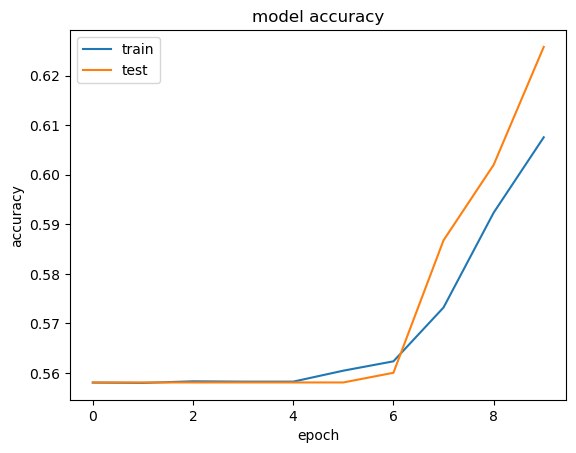

In [57]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

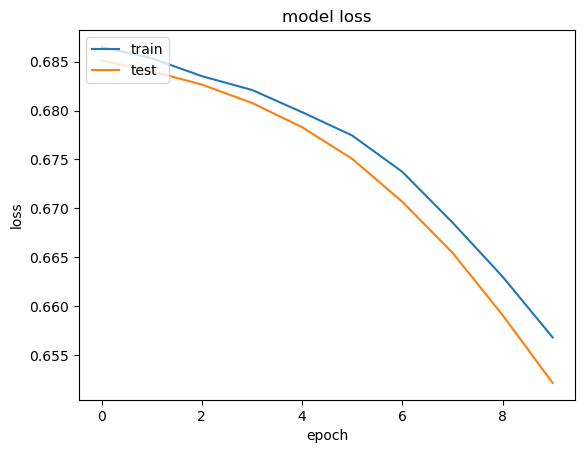

In [58]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [59]:
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
y_pred = model.predict(X_test)

161/161 [==============================] - 14s 87ms/step


In [60]:
binary_predictions = []

for i in y_pred:
    if i >= 0.5:
        binary_predictions.append(1)
    else:
        binary_predictions.append(0)

In [61]:
print("---Test Set Results---")
print("Accuracy with NN: {}".format(accuracy_score(y_test, binary_predictions)))

---Test Set Results---
Accuracy with NN: 0.6258051922701542


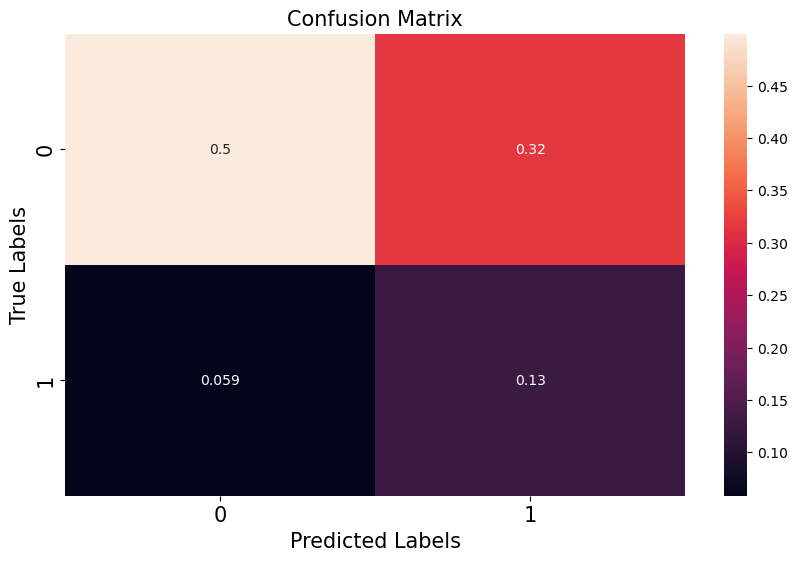

In [62]:
import matplotlib.pyplot as plt
import seaborn as sns
matrix = confusion_matrix(binary_predictions, y_test, normalize='all')
plt.figure(figsize=(10, 6))
ax= plt.subplot()
sns.heatmap(matrix, annot=True, ax = ax)

# labels, title and ticks
ax.set_xlabel('Predicted Labels', size=15)
ax.set_ylabel('True Labels', size=15)
ax.set_title('Confusion Matrix', size=15)
ax.xaxis.set_ticklabels([0,1], size=15)
ax.yaxis.set_ticklabels([0,1], size=15);

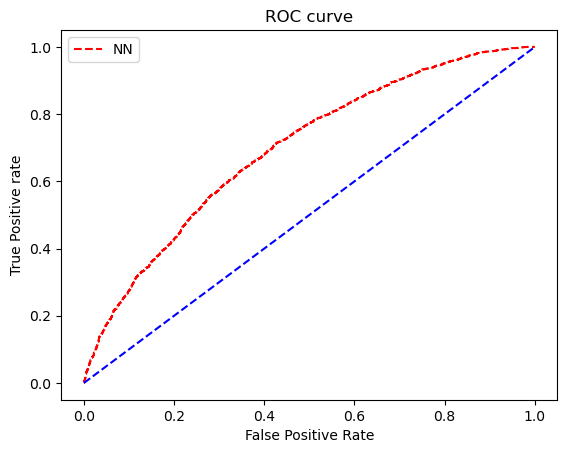

AUC score: 0.6961


In [63]:
from sklearn.metrics import roc_curve, roc_auc_score, auc

fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test, y_pred)

auc_score1 = auc(fpr_keras, tpr_keras)

# plot roc curves
# plt.plot(fpr1, tpr1, linestyle='--',color='orange', label='Logistic Regression')
plt.plot(fpr_keras, tpr_keras, linestyle='--',color='red', label='NN')
plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')
# title
plt.title('ROC curve')
# x label
plt.xlabel('False Positive Rate')
# y label
plt.ylabel('True Positive rate')

plt.legend(loc='best')
plt.show();

print('AUC score:',round(auc_score1, 4))

## LSTM

In [64]:
# Bert layers
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
preprocessed_text = bert_preprocess(text_input)
outputs = bert_encoder(preprocessed_text)

# Neural network layers
hidden1 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(embedding_dim, return_sequences=True))(outputs['sequence_output'])
dropout1 = tf.keras.layers.Dropout(0.1, name="dropout")(hidden1)
hidden2 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32))(dropout1)
dropout2 = tf.keras.layers.Dropout(0.1, name="dropout2")(hidden2)
hidden3 = tf.keras.layers.Dense(16, activation='sigmoid')(dropout2)
l = tf.keras.layers.Dense(1, activation='sigmoid', name="output")(hidden3)

# Use inputs and outputs to construct a final model
model = tf.keras.Model(inputs=[text_input], outputs = [l])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 keras_layer (KerasLayer)       {'input_type_ids':   0           ['text[0][0]']                   
                                (None, 128),                                                      
                                 'input_word_ids':                                                
                                (None, 128),                                                      
                                 'input_mask': (Non                                               
                                e, 128)}                                                    

In [65]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)
METRICS = [tf.keras.metrics.BinaryAccuracy(name='accuracy')]
model.compile(loss=tf.keras.losses.BinaryCrossentropy(), optimizer=tf.keras.optimizers.Adam(1e-4), metrics=METRICS)

In [66]:
history = model.fit(X_train, y_train, epochs=10,validation_split=0.1, batch_size=30, shuffle=True, callbacks=[early_stop])

Epoch 1/10
462/462 [==============================] - 98s 201ms/step - loss: 0.6082 - accuracy: 0.6734 - val_loss: 0.5657 - val_accuracy: 0.7196
Epoch 2/10
462/462 [==============================] - 91s 196ms/step - loss: 0.5512 - accuracy: 0.7281 - val_loss: 0.5513 - val_accuracy: 0.7235
Epoch 3/10
462/462 [==============================] - 84s 183ms/step - loss: 0.5340 - accuracy: 0.7375 - val_loss: 0.5377 - val_accuracy: 0.7287
Epoch 4/10
462/462 [==============================] - 87s 187ms/step - loss: 0.5219 - accuracy: 0.7460 - val_loss: 0.5330 - val_accuracy: 0.7293
Epoch 5/10
462/462 [==============================] - 84s 182ms/step - loss: 0.5117 - accuracy: 0.7516 - val_loss: 0.5207 - val_accuracy: 0.7534
Epoch 6/10
462/462 [==============================] - 86s 187ms/step - loss: 0.5048 - accuracy: 0.7575 - val_loss: 0.5168 - val_accuracy: 0.7521
Epoch 7/10
462/462 [==============================] - 91s 198ms/step - loss: 0.5000 - accuracy: 0.7616 - val_loss: 0.5119 - val_ac

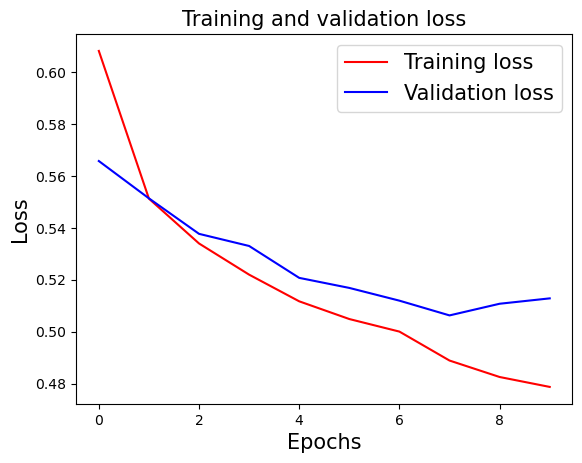

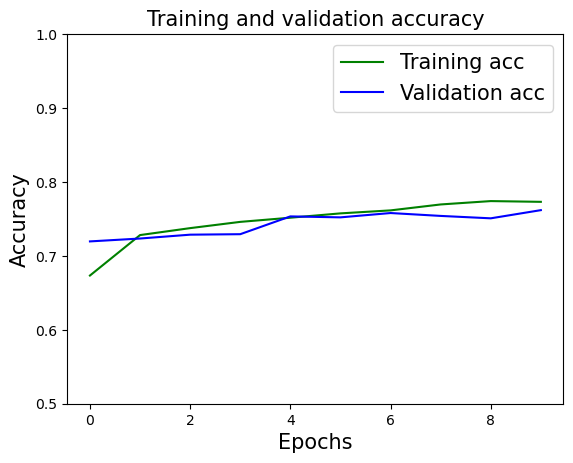

In [67]:
history_dict = history.history

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']
epochs = history.epoch

# plt.figure(figsize=(10,6))
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss', size=15)
plt.xlabel('Epochs', size=15)
plt.ylabel('Loss', size=15)
plt.legend(prop={'size': 15})
plt.show()

# plt.figure(figsize=(10,6))
plt.plot(epochs, acc, 'g', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy', size=15)
plt.xlabel('Epochs', size=15)
plt.ylabel('Accuracy', size=15)
plt.legend(prop={'size': 15})
plt.ylim((0.5,1))
plt.show()

In [68]:
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
pred = model.predict(X_test)

binary_predictions = []

for i in pred:
    if i >= 0.5:
        binary_predictions.append(1)
    else:
        binary_predictions.append(0)

161/161 [==============================] - 22s 127ms/step


---Test Set Results---
Accuracy: 0.7464


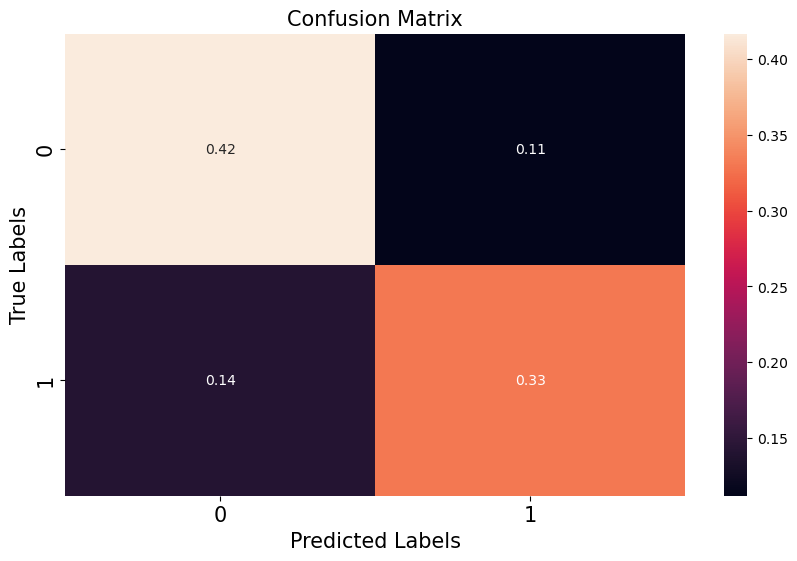

In [69]:
import seaborn as sns
print("---Test Set Results---")
matrix = confusion_matrix(binary_predictions, y_test, normalize='all')
plt.figure(figsize=(10, 6))
ax= plt.subplot()
sns.heatmap(matrix, annot=True, ax = ax)

# labels, title and ticks
ax.set_xlabel('Predicted Labels', size=15)
ax.set_ylabel('True Labels', size=15)
ax.set_title('Confusion Matrix', size=15)
ax.xaxis.set_ticklabels([0,1], size=15)
ax.yaxis.set_ticklabels([0,1], size=15);

print("Accuracy: {:.4f}".format(accuracy_score(y_test, binary_predictions)))

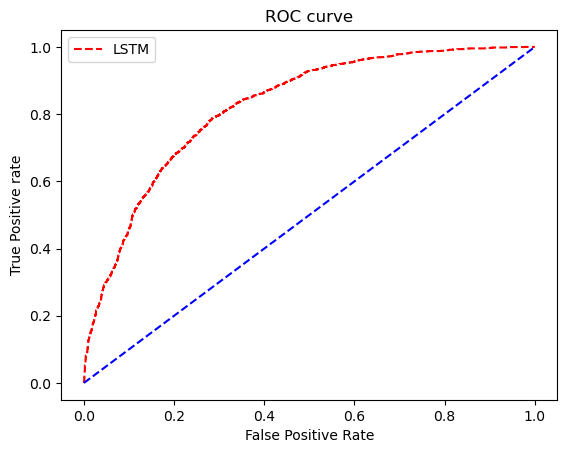

AUC score: 0.8229


In [70]:
from sklearn.metrics import roc_curve, roc_auc_score, auc

fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test, pred)

auc_score1 = auc(fpr_keras, tpr_keras)

# plot roc curves
# plt.plot(fpr1, tpr1, linestyle='--',color='orange', label='Logistic Regression')
plt.plot(fpr_keras, tpr_keras, linestyle='--',color='red', label='LSTM')
plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')
# title
plt.title('ROC curve')
# x label
plt.xlabel('False Positive Rate')
# y label
plt.ylabel('True Positive rate')

plt.legend(loc='best')
plt.show();

print('AUC score:',round(auc_score1, 4))